# Network inference from Brian network

In [7]:
from brian2 import *
import pandas as pd
%matplotlib inline

filename = None#"data_N1000_T300_naLIF_currentsyn"

Nneurons_obs = 30  # number of neurons whose spike trains are observed
Nneurons_tot = 500  # number of neurons in total;
sim_t = 30*second #simulation time
rate_min = 1

set_device('cpp_standalone')


### Network

In [8]:
device.reinit()
device.activate()

if filename is None: #only simulate new network if required
    
    ######################
    ##### PARAMETERS #####
    ######################
    N_e = int(0.8*Nneurons_tot) #number of excitatory neurons
    N_i = Nneurons_tot - N_e #number of inhibitory neurons
    
    # neuron model parameters:
    C = 281 * pF
    gL = 30 * nS
    taum = C / gL
    EL = -70.6 * mV
    VT = -50.4 * mV
    DeltaT = 2 * mV
    Vcut = VT + 5 * DeltaT
    I_ex = 1.0*nA #external current
    
    # Pick an electrophysiological behaviour
    tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, -70.6*mV # Regular spiking (as in the paper)
    
    # Synapses
    pe = 0.1 #excitatory connection probability
    pi = 0.2 #inhibitory connection probability
    d = 1.0 #synaptic delay
    # Reversal potentials
    Ee = 0*mV
    Ei = -80*mV
    we_init = 6*nS  # excitatory synaptic weight
    wi_init = 67*nS  # inhibitory synaptic weight
    taue = 5*ms
    taui = 10*ms
    ge_init = 1.0*nS
    gi_init=3.0*nS
    
    # input parameters:
    np.random.seed(20)   
    
    print('Number of excitatory neurons:',N_e)
    print('Number of inhibitory neurons:',N_i)
    
    ######################
    ###### NETWORK #######
    ######################   
    eqs = '''
    dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) -ge*(vm-Ee) - gi*(vm-Ei) + I - w)/C : volt
    dw/dt = (a*(vm - EL) - w)/tauw : amp 
    I:amp
    dge/dt = -ge/taue : siemens
    dgi/dt = -gi/taui : siemens   
    '''
    
    # neurons
    G = NeuronGroup(Nneurons_tot, eqs,method='euler',
                    threshold='vm>Vcut',
                    reset="vm=Vr; w+=b",
                    #refractory=T_ref
                   )
    
    # intial values
    G.vm = EL
    G.I = 'rand()*I_ex'
    G.ge = ge_init
    G.gi = gi_init
    
    # synapses
    Se = Synapses(G[:N_e], G, 'we: siemens', on_pre='ge += we')
    Si = Synapses(G[N_e:], G, 'wi: siemens', on_pre='gi += wi')
    Se.connect('i!=j', p=pe)
    Si.connect('i!=j', p=pi)
    Se.we = we_init#"we_init*rand()" # random excitatory synaptic weight (voltage)
    Si.wi = wi_init#"wi_init*rand()" # random inhibitory synaptic weight
    Se.delay = d
    Si.delay = d
    
    # spikes
    spikemon = SpikeMonitor(G, record=True)
    run(sim_t, report='text')
    
    # discard first 5 seconds
    sptimes = spikemon.t/ms
    print(sptimes)
    #idx = sptimes > 5000
    spid = spikemon.i#[idx]
    #sptimes = sptimes[idx]
    #sptimes -= 5000

    # weights
    Jmat = np.zeros((Nneurons_tot, Nneurons_tot))
    Jmat[Se.i,Se.j] = Se.we/mV
    Jmat[Si.i + N_e, Si.j] = Si.wi/mV
    
    # save data as pandas dataframe
    df = pd.DataFrame(columns=['spiketimes','spikeid','Nobs','Ntot','Jmat','Jmat_obs','obs_neurons','sim_time'])
    df = df.append({'spiketimes': sptimes,
                    'spikeid': np.array(spid),
                    'Ntot': Nneurons_tot,
                    'Jmat': Jmat,
                    'sim_time': sim_t/second
                    }, ignore_index=True)
    
    filename = 'data_N'+str(Nneurons_tot)+'_T'+str(int(sim_t/second))
    print('File saved: %s' %filename)
    df.to_pickle(filename+'.pkl')
else:
    print("Loading results from file: %s.pkl" %filename)

WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 330. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 330. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


('Number of excitatory neurons:', 400)
('Number of inhibitory neurons:', 100)
[1.21000e+01 1.22000e+01 1.22000e+01 ... 2.99992e+04 2.99996e+04
 2.99998e+04]
File saved: data_N500_T30


### Load already existing data

WARNING    /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in divide
 [py.warnings]


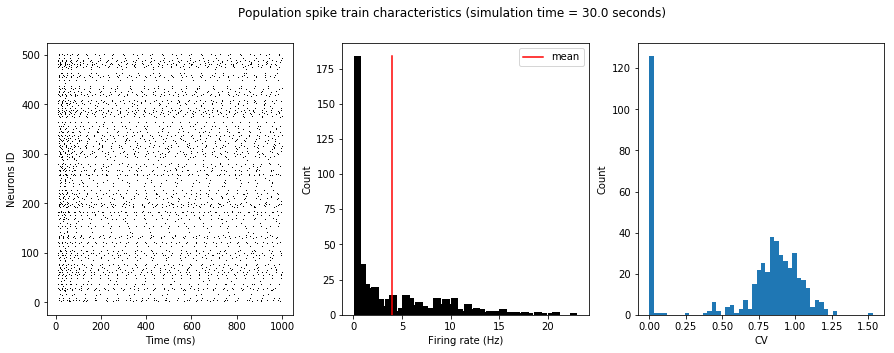

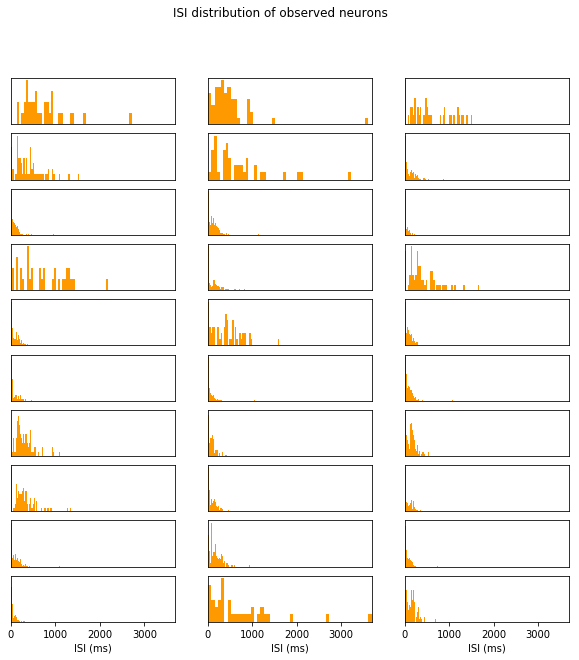

In [9]:
# load data --------------
if filename is not None:
    df = pd.read_pickle(filename+".pkl")
    
sptimes = df['spiketimes'][0]
spid = df['spikeid'][0]
Nneurons_tot = df['Ntot'][0]
Jmat = df['Jmat'][0]
sim_t = df['sim_time'][0]

# VISUALIZE SPIKE PROPERTIES OF OBSERVED NEURONS --------------
ISI = {}
ISIstat = {
    'count':np.zeros(Nneurons_tot),
    'mean': np.zeros(Nneurons_tot),
    'std':np.zeros(Nneurons_tot),
    'cv':np.zeros(Nneurons_tot)
}
for i_N in range(Nneurons_tot):
    ISI[i_N] = np.diff(sptimes[spid==i_N])
    ISIstat['count'][i_N] = len(ISI[i_N])
    if ISIstat['count'][i_N]!=0:
        ISIstat['mean'][i_N] = np.mean(ISI[i_N])
        ISIstat['std'][i_N] = np.std(ISI[i_N])
        ISIstat['cv'][i_N] = np.std(ISI[i_N])/np.mean(ISI[i_N])
    else:
        ISIstat['cv'][i_N] = 0
        
figure(figsize=(15,5))
suptitle('Population spike train characteristics (simulation time = '+str(sim_t)+' seconds)')
# raster
subplot(131)
idx = np.array(sptimes) < 1000
plot(sptimes[idx],spid[idx],'k,',lw=0)
ylabel('Neurons ID')
xlabel('Time (ms)')

# firing rate
subplot(132)
fr = 1/(ISIstat['mean']/1000)
fr[np.isinf(fr)] = 0
count,edges = np.histogram(fr,bins=50)
bar(edges[1:]-edges[:-1]+edges[:-1],count,facecolor='k')
plot([np.mean(fr),np.mean(fr)],[0,np.max(count)],'r',label='mean')
xlabel('Firing rate (Hz)')
ylabel('Count')
legend()

# coefficient of variation
subplot(133)
hist(ISIstat['cv'],50)
xlabel('CV')
ylabel('Count')
#savefig('plots/%s_population.pdf' %filename)

figure(figsize=(10,10))
suptitle('ISI distribution of observed neurons')

# change observed neurons id to neurons with at least mean fr=5 Hz
np.random.seed(100)

obs_neurons_ind = np.random.choice(np.where(fr>=rate_min)[0],Nneurons_obs)
Jmat_obs = Jmat[obs_neurons_ind,:][:,obs_neurons_ind] #connectivity matrix of observed neurons

nb_cols = 3
nb_rows = int(ceil(Nneurons_obs/float(nb_cols)))
x_max = np.max([np.max(ISI[i]) for i in obs_neurons_ind])

for count,ind in enumerate(obs_neurons_ind):
    subplot(nb_rows,nb_cols,count+1)
    hist(ISI[ind],50,facecolor=[1,0.6,0])
    yticks([], [])
    xlim((0,x_max))
    if count<(nb_rows-1)*nb_cols:
        xticks(())
    else:
        xlabel('ISI (ms)')
    
    
#savefig('plots/%s_ISI_dist.pdf' %filename)
show()

# into dictionary
Spt_dict = {}
for i_N,id_N in enumerate(obs_neurons_ind):
    idx = np.where(spid == id_N)[0]
    Spt_dict[i_N] = sptimes[idx]


### Cross correlogram

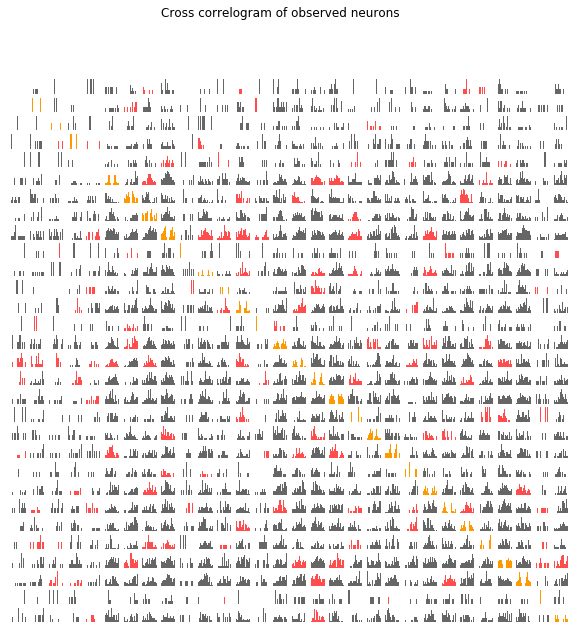

Red: neuron of row ID excites neuron of column ID


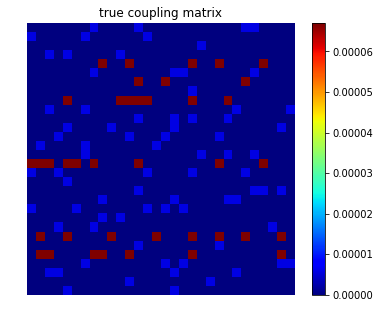

In [11]:
def crosscorr(x1,x2,steps):
    ac = np.array([np.correlate(x1[:-t],x2[t:])[0] for t in steps[steps>0]])
    ac = np.insert(ac,0,np.correlate(x1,x2)[0])
    ac2 = np.array([np.correlate(x1[t:],x2[:-t])[0] for t in abs(steps[steps<0])])
    ac = np.concatenate([ac2,ac])
    return ac

# binary spike matrix for correlation
spikes = np.zeros((Nneurons_obs,int(sim_t)*1000))
for i_N in range(Nneurons_obs):
    spikes[i_N,Spt_dict[i_N].astype(int)] = 1.0
        
        
obs_time = 300 #sec of raster to use
stepsize = 1 #ms

maxlag = 40.0 #ms
steps = np.arange(-int(maxlag),int(maxlag)+1,stepsize) #omit 0 lag

f = figure(figsize=(10,10))
suptitle('Cross correlogram of observed neurons')
sp = 1
Jcg = np.zeros((Nneurons_obs,Nneurons_obs))
for i_N in range(Nneurons_obs):
    for j_N in range(Nneurons_obs):
        x1 = spikes[i_N,:obs_time*1000]
        x2 = spikes[j_N,:obs_time*1000]

        cg = crosscorr(x1,x2,steps)
        if i_N==j_N:
            cg[len(cg)/2] = 0
        
        col = [0.4,0.4,0.4]
        if i_N==j_N:
            col = [1,0.6,0]
        elif Jmat_obs[i_N,j_N]>0:
            col = [1,0.3,0.3]
        elif Jmat_obs[i_N,j_N]<0:
            col = [0,0.6,0.9]
        #Jcg[j_N,i_N] = cg[len(cg)/2+1] - np.mean(cg)
            
        ax = f.add_subplot(Nneurons_obs,Nneurons_obs,sp)
        bar(steps,cg,width=stepsize,facecolor=col)
        if i_N<(Nneurons_obs-1)*Nneurons_obs:
            ax.set_xticks([])
        
        ax.set_yticks([])
        box()
        sp += 1
show()

print 'Red: neuron of row ID excites neuron of column ID'

# visualize connectivity matrix    
figure(figsize=(6,5))
subplot(111)
imshow(Jmat_obs, origin='upper', interpolation='nearest', 
           aspect='auto', cmap=plt.cm.jet)
title('true coupling matrix')
colorbar()
axis('off')
show()    